In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import cv2 as cv
import easyocr
reader = easyocr.Reader(['en']) 

In [2]:
filename = 'noisy.jpg'

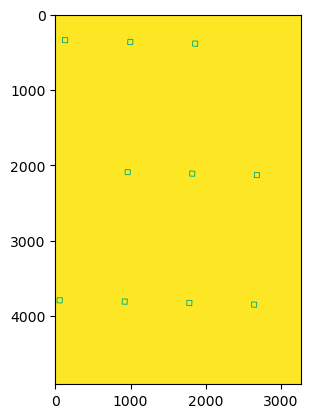

In [3]:
results = []
results_detail = []
img = cv.imread(filename)[:,:,1]
img_blur = cv.GaussianBlur(img, (5,5),0)
edges = cv.Canny(img_blur, 50, 150)
size_min, size_max = (60,85)
x_step = 250.0
y_step = 500.0
# ocr_threshold = 140

contours, _ = cv.findContours(edges, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
img_canvas = 255*np.ones(img.shape).astype(np.uint8).copy()
index = 0
for contour in contours:
    epsilon = 0.05 * cv.arcLength(contour, True)
    approx = cv.approxPolyDP(contour, epsilon, True)
    
    # If the polygon has 4 vertices, it could be a square
    if len(approx) == 4:
        # Check if it's roughly a square
        # x, y, w, h = cv.boundingRect(approx)
        (x, y), (w, h), angle = cv.minAreaRect(approx)
        
         
        aspect_ratio = float(w) / h
        if 0.8 <= aspect_ratio <= 1.2:  # Square-like aspect ratio
            # Further checks on size and location of square
            
            if size_min <= w <= size_max and size_min <= h <= size_max and -15 <= angle <= angle:
                # Draw the square or mark it as detected
                # print(angle)
                x = int(x)
                y = int(y)
                results.append([x, y])
                results_detail.append([x, y, w, h, angle])

                cv.drawContours(img_canvas , [approx], 0, (0, 255, 0), 3)
# cv.imshow("Detected Square", img_canvas)
# cv.waitKey(0)
# cv.destroyAllWindows()
results = np.array(results)
results_detail = np.array(results_detail)
plt.imshow(img_canvas)

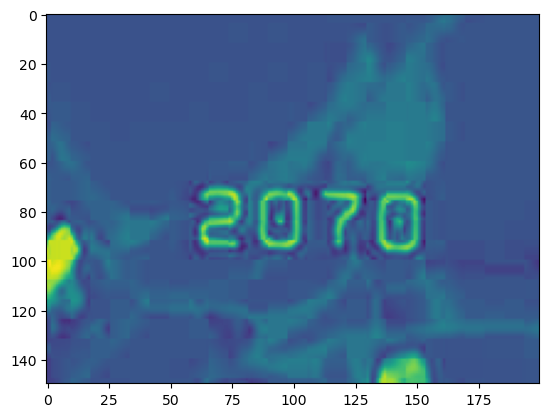

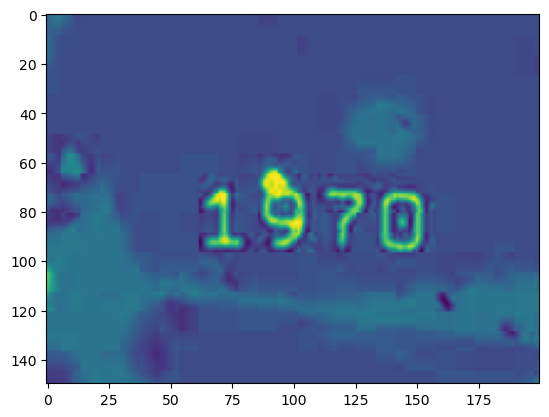

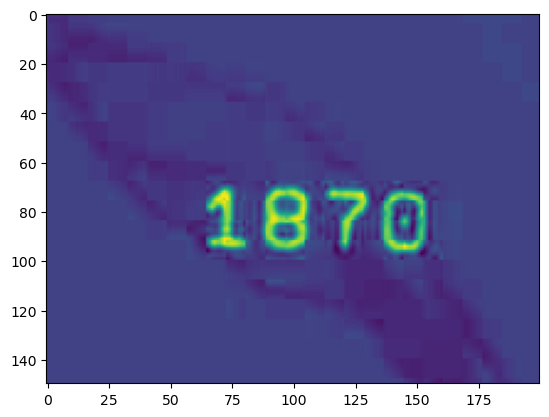

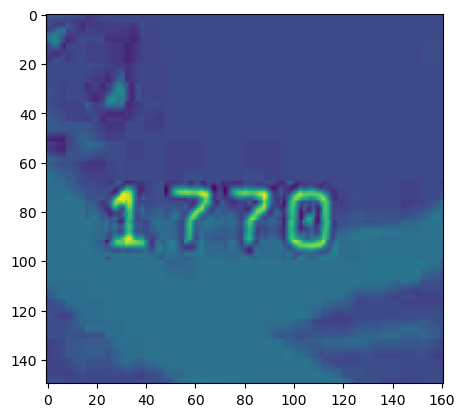

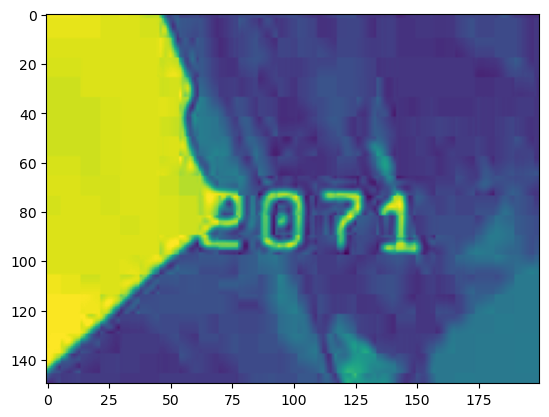

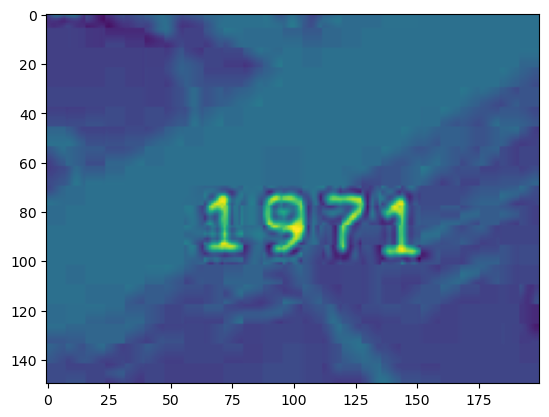

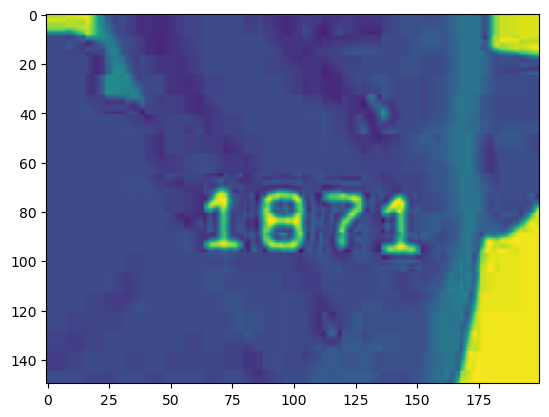

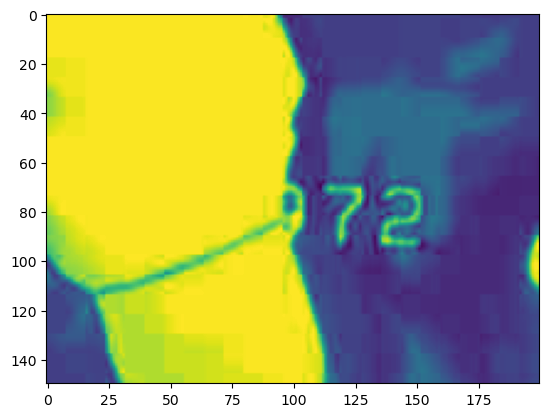

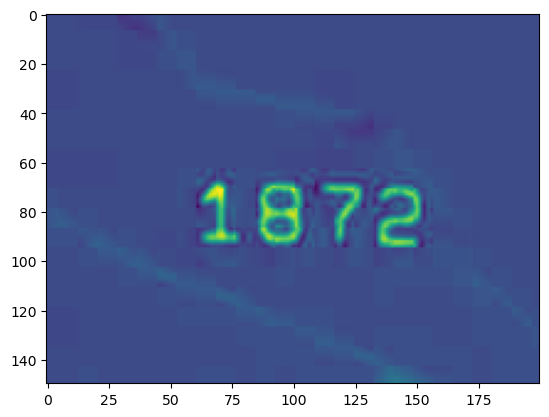

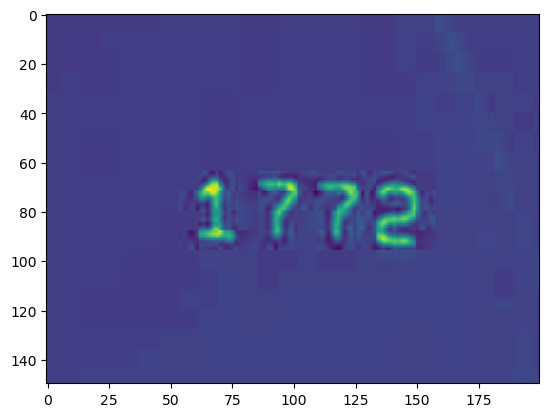

In [4]:
ocr_results = []
ocr_results_detail = []
for index, result in enumerate(results):
    y, x = result
    y_view = 100
    x_view_start = -250
    x_view_end = -100
    img_ocr = img[
        max(0,x+x_view_start):min(img.shape[0],x+x_view_end), 
        max(0,y-y_view):min(img.shape[1],y+y_view)]
    
    # img_ocr = np.where(img_ocr > ocr_threshold, 255, 0).astype(np.uint8).copy()
    _, ID, prob = reader.readtext(img_ocr, allowlist='0123456789')[0]
    if len(ID) == 4 and prob >= 0.000:
        ocr_results.append([ID, prob])
        x_rec, y_rec, w_rec, h_rec, angle_rec = results_detail[index]
        location_params = [int(ID), int(x_rec), int(y_rec), angle_rec]
        ocr_results_detail.append(location_params)
    plt.imshow(img_ocr)
    plt.show()

In [5]:
ocr_results

[['2070', 0.9999814033508301],
 ['1970', 0.9999962449073792],
 ['1870', 0.9986616373062134],
 ['1770', 0.7049827644848986],
 ['2071', 0.999929666519165],
 ['1971', 0.9973690509796143],
 ['1871', 0.5889228582382202],
 ['1872', 0.9792414903640747],
 ['1772', 0.9998427033424377]]

In [6]:
coords = ((results - results[0])* 0.29072)[1:,:]

In [7]:
coords

array([[ -250.0192 ,    -6.10512],
       [ -499.74768,   -11.6288 ],
       [ -750.34832,   -16.28032],
       [   10.46592,  -499.45696],
       [ -238.97184,  -505.27136],
       [ -487.82816,  -510.79504],
       [ -227.34304, -1006.47264],
       [ -477.65296, -1012.57776],
       [ -729.12576, -1019.84576]])

In [8]:
approx = np.sqrt(np.sum(coords**2, axis=1))[:4]/250.00

In [16]:
np.mean(approx/np.round(approx))

0.9999934810314599

In [10]:

ref_coords = np.round(np.divide(coords, [x_step, y_step])) @ np.diag([x_step, y_step]) + 1E-8

In [11]:
ref_coords

array([[-2.5e+02,  1.0e-08],
       [-5.0e+02,  1.0e-08],
       [-7.5e+02,  1.0e-08],
       [ 1.0e-08, -5.0e+02],
       [-2.5e+02, -5.0e+02],
       [-5.0e+02, -5.0e+02],
       [-2.5e+02, -1.0e+03],
       [-5.0e+02, -1.0e+03],
       [-7.5e+02, -1.0e+03]])

In [12]:
rot_angles = (np.arctan2(coords[:,1], coords[:,0]) - np.arctan2(ref_coords[:,1],ref_coords[:,0]) )/ np.pi * 180.0
corrected_rot_angles = rot_angles - np.round(np.divide(rot_angles, 360.0)) * 360.0

In [13]:
rot_angle_mean = np.mean(corrected_rot_angles)

In [14]:
# ocr_results = []
# for index, result in enumerate(results):
#     y, x = result
#     y_view = 100
#     x_view_start = -250
#     x_view_end = 100
    
#     img_ocr = img[
#         max(0,x+x_view_start):min(img.shape[0],x+x_view_end), 
#         max(0,y-y_view):min(img.shape[1],y+y_view)]
#     rot_angle_img = rot_angle_mean
#     results_detail[index][4]
#     rotated_img = ndimage.rotate(img_ocr,  rot_angle_mean)
    
#     # img_ocr = np.where(img_ocr > ocr_threshold, 255, 0).astype(np.uint8).copy()

#     plt.imshow(rotated_img)
#     plt.show()

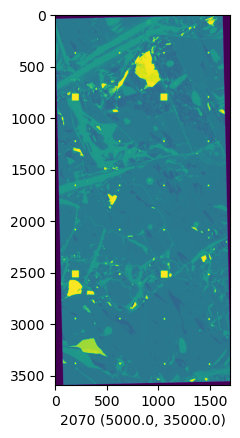

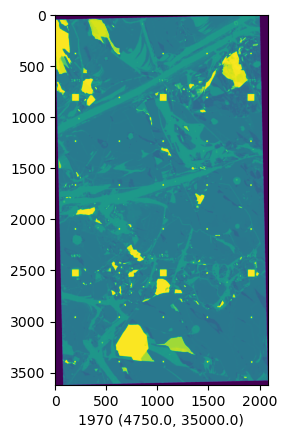

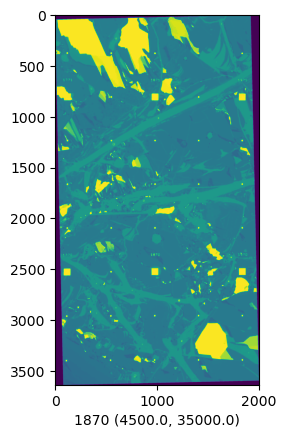

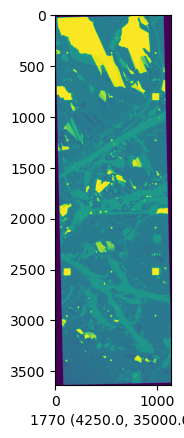

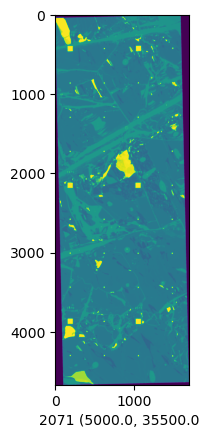

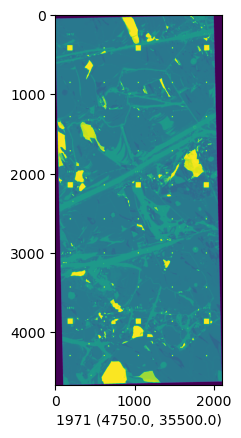

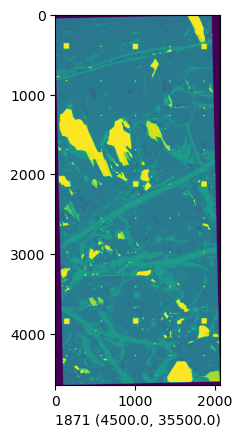

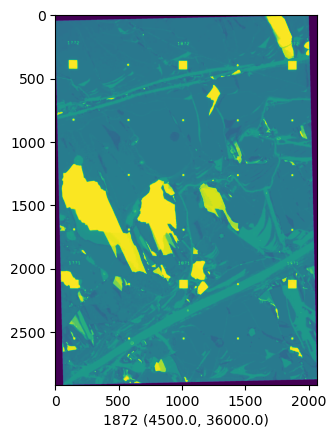

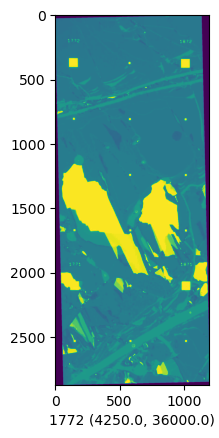

In [15]:
# ocr_results = []
for index, result in enumerate(ocr_results_detail):
    ID, y, x, angle = result
    y_view = 1000
    x_view_start = -2500
    x_view_end = 2500
    
    img_ocr = img[
        max(0,x+x_view_start):min(img.shape[0],x+x_view_end), 
        max(0,y-y_view):min(img.shape[1],y+y_view)]
    rot_angle_img = rot_angle_mean
    results_detail[index][4]
    rotated_img = ndimage.rotate(img_ocr, rot_angle_img)
    
    # img_ocr = np.where(img_ocr > ocr_threshold, 255, 0).astype(np.uint8).copy()

    plt.imshow(rotated_img)
    ax = plt.gca()
    location = (x_step * (ID //100 ), y_step * (ID % 100))
    ax.set_xlabel(str(ID) + ' ' + str(location))
    plt.show()